# Import Packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ovm.monetary.model import MonetaryModel

import logging
import random
import typing as tp

import line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
from mesa.datacollection import DataCollector
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule
from tqdm import tqdm

from ovm.monetary.agents import (
    MonetaryAgent, 
    MonetaryArbitrageur, 
    MonetaryKeeper
)

from ovm.monetary.markets import MonetaryFMarket
from ovm.monetary.model import MonetaryModel
from ovm.monetary.options import DataCollectionOptions
from ovm.monetary.plot_labels import (
    price_deviation_label,
    spot_price_label,
    futures_price_label,
    skew_label,
    inventory_wealth_ovl_label,
    inventory_wealth_usd_label,
    GINI_LABEL,
    GINI_ARBITRAGEURS_LABEL,
    SUPPLY_LABEL,
    TREASURY_LABEL,
    LIQUIDITY_LABEL, 
    is_deviation_label, 
    is_spot_price_label, 
    is_futures_price_label, 
    is_skew_label
)

from ovm.monetary.reporters import *
from ovm.monetary.data_io import construct_ticker_to_series_of_prices_map

from ovm.tickers import (
    ETH_USD_TICKER,
    COMP_USD_TICKER,
    LINK_USD_TICKER,
    YFI_USD_TICKER
)

from ovm.time_resolution import TimeResolution
DEFAULT_FIGURE_SIZE = (8, 6)

In [3]:
logger = logging.getLogger(__name__)
logger.level

0

In [4]:
logging.getLevelName(logging.root.level)

'WARNING'

In [5]:
logging.root.level

30

In [6]:
%load_ext line_profiler

# Set Parameters

In [7]:
number_of_steps_to_simulate = 1000

TIME_RESOLUTION = TimeResolution.FIFTEEN_SECONDS
DATA_SIM_RNG = 42

TICKERS = [ETH_USD_TICKER,
           # not a long history of simulation (can we use a different token instead)
           COMP_USD_TICKER,
           # not a long history of simulation (can we use a different token instead)
           LINK_USD_TICKER,
           # less than half a year of simulation (can we use a different token instead)
           YFI_USD_TICKER
           ]

OVL_USD_REPLACEMENT_TICKER = 'YFI-USD'
OVL_USD_TICKER = 'OVL-USD'

TICKERS_WITH_OVL = [OVL_USD_TICKER if ticker == OVL_USD_REPLACEMENT_TICKER else ticker for ticker in TICKERS]
TICKERS_WITH_OVL

['ETH-USD', 'COMP-USD', 'LINK-USD', 'OVL-USD']

In [8]:
# skew_labels = [skew_label(ticker) for ticker in TICKERS]
# skew_labels

# Load Data

In [9]:
ticker_to_time_series_of_prices_map = \
    construct_ticker_to_series_of_prices_map(data_sim_rng=DATA_SIM_RNG,
                                             time_resolution=TIME_RESOLUTION,
                                             tickers=TICKERS, 
                                             ovl_ticker=OVL_USD_REPLACEMENT_TICKER)

In [10]:
# """
# Configure visualization elements and instantiate a server
# """


# def random_color():
#     return '#%02X%02X%02X' % (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))



# Constants
STEPS_MONTH = int((86400*30) / TIME_RESOLUTION.in_seconds)



total_supply = 100000  # OVL
base_wealth = 0.0001*100000  # OVL
base_market_fee = 0.0030
base_max_leverage = 10.0
time_liquidity_mine = STEPS_MONTH

# For the first 30 days, emit until reach 100% of total supply; ONLY USE IN LIQUDITIY FOR NOW JUST AS TEST!
liquidity_supply_emission = [(0.51*total_supply/time_liquidity_mine)*i + 0.285*total_supply
                             for i
                             in range(time_liquidity_mine)]

num_arbitrageurs = max(len(ticker_to_time_series_of_prices_map.keys()) * 5,
                       int(total_supply*0.01/base_wealth))
num_keepers = max(len(ticker_to_time_series_of_prices_map.keys()), int(total_supply * 0.005 / base_wealth))
num_traders = int(total_supply*0.2/base_wealth)
num_holders = int(total_supply*0.5/base_wealth)
num_agents = num_arbitrageurs + num_keepers + num_traders + num_holders

liquidity = 0.285*total_supply
treasury = 0.0
sampling_interval = 240

# TODO: Vary these initial num_ ... numbers; for init, reference empirical #s already seeing for diff projects
MODEL_KWARGS = {
    "ticker_to_time_series_of_prices_map": ticker_to_time_series_of_prices_map,
    "num_arbitrageurs": num_arbitrageurs,
    "num_keepers": num_keepers,
    "num_traders": num_traders,
    "num_holders": num_holders,
    "base_wealth": base_wealth,
    "base_market_fee": base_market_fee,
    "base_max_leverage": base_max_leverage,
    # Setting liquidity = 100x agent-owned OVL for now; TODO: eventually have this be a function/array
    "liquidity": liquidity,
    "liquidity_supply_emission": liquidity_supply_emission,
    "treasury": treasury,
    # TODO: 1920 ... 8h with 15s blocks (sim simulation is every 15s)
    "sampling_interval": sampling_interval,
}

data_collection_options = \
    DataCollectionOptions(perform_data_collection=True, 
                          compute_gini_coefficient=False,
                          compute_wealth=False,
                          compute_inventory_wealth=False)


monetary_model = \
    MonetaryModel(num_arbitrageurs=num_arbitrageurs, 
                  num_keepers=num_keepers, 
                  num_traders=num_traders, 
                  num_holders=num_holders, 
                  ticker_to_time_series_of_prices_map=ticker_to_time_series_of_prices_map, 
                  base_wealth=base_wealth, 
                  base_market_fee=base_market_fee, 
                  base_max_leverage=base_max_leverage, 
                  liquidity=liquidity, 
                  liquidity_supply_emission=liquidity_supply_emission, 
                  treasury=treasury, 
                  sampling_interval=sampling_interval, 
                  data_collection_options=data_collection_options)

In [11]:
for i in range(number_of_steps_to_simulate):
    monetary_model.step()

In [12]:
def run_model(number_of_steps_to_simulate: int):
    for i in range(number_of_steps_to_simulate):
        monetary_model.step()

In [13]:
# %lprun \
#     -f compute_gini \
#     -f compute_price_difference \
#     -f compute_futures_price \
#     -f compute_spot_price \
#     -f compute_supply \
#     -f compute_liquidity \
#     -f compute_treasury \
#     -f compute_wealth_for_agent_type \
#     -f compute_inventory_wealth_for_agent \
#     -f compute_inventory_wealth_for_agent_type \
#     -f compute_positional_imbalance_by_market \
#     -f DataCollector.collect \
#     -f MonetaryAgent.step \
#     -f MonetaryArbitrageur._unwind_positions \
#     -f MonetaryArbitrageur._unwind_next_position \
#     -f MonetaryArbitrageur.trade \
#     -f MonetaryArbitrageur.step \
#     -f MonetaryKeeper.step \
#     -f MonetaryKeeper.distribute_funding \
#     -f MonetaryFMarket.build \
#     -f MonetaryFMarket.unwind \
#     -f MonetaryFMarket._swap \
#     -f MonetaryFMarket.fund \
#     -f MonetaryModel.step \
#     run_model(number_of_steps_to_simulate)

In [14]:
model_vars_df = monetary_model.data_collector.get_model_vars_dataframe()
model_vars_df.head()

,d-ETH-USD,d-COMP-USD,d-LINK-USD,d-OVL-USD,s-ETH-USD,s-COMP-USD,s-LINK-USD,s-OVL-USD,f-ETH-USD,f-COMP-USD,f-LINK-USD,f-OVL-USD,Skew ETH-USD,Skew COMP-USD,Skew LINK-USD,Skew OVL-USD,Supply,Treasury,Liquidity
0,0.000000,0.000000,0.000000,0.000000,284.578702,157.277894,7.707481,3565.000000,284.578702,157.277894,7.707481,3565.0,0.0,0.0,0.000,0.0,100000.0000,0.0000,28500.0
1,0.000000,0.000000,0.000000,0.000000,284.578702,157.277894,7.707481,3565.000000,284.578702,157.277894,7.707481,3565.0,0.0,0.0,0.000,0.0,100000.0000,0.0000,28500.0
2,0.000069,0.000000,-0.008617,0.000000,284.559134,157.277894,7.774473,3565.000000,284.578702,157.277894,7.707481,3565.0,0.0,0.0,0.000,0.0,100000.0000,0.0000,28500.0
3,-0.000389,-0.001381,-0.015742,0.000000,284.689582,157.495320,7.830755,3565.000000,284.578702,157.277894,7.707481,3565.0,0.0,0.0,0.000,0.0,100000.0000,0.0000,28500.0
4,-0.000412,-0.001381,-0.011388,-0.016055,284.696105,157.495320,7.835585,3623.170163,284.578702,157.277894,7.746356,3565.0,0.0,0.0,8.973,0.0,99999.9865,0.0135,28500.0


In [15]:
# [column_name for column_name in model_vars_df.columns if column_name.startswith('Skew')]

In [16]:
# plt.figure(1);
# for column_name in model_vars_df.columns:
#     if is_skew_label(column_name):
#         plt.plot(model_vars_df.loc[:, column_name], label=column_name);
# plt.legend();

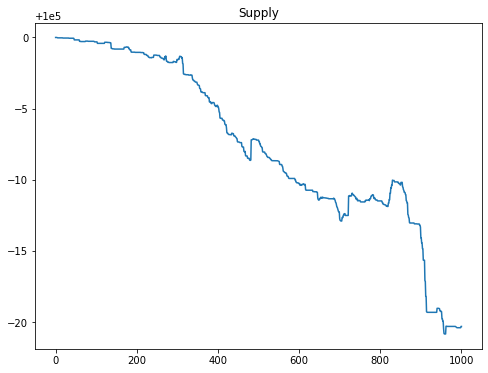

In [17]:
plt.figure(0, figsize=DEFAULT_FIGURE_SIZE);
plt.plot(model_vars_df.loc[:, SUPPLY_LABEL]);
plt.title(SUPPLY_LABEL);

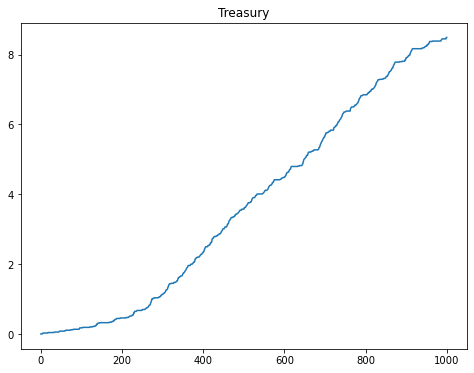

In [18]:
plt.figure(0, figsize=DEFAULT_FIGURE_SIZE);
plt.plot(model_vars_df.loc[:, TREASURY_LABEL]);
plt.title(TREASURY_LABEL);

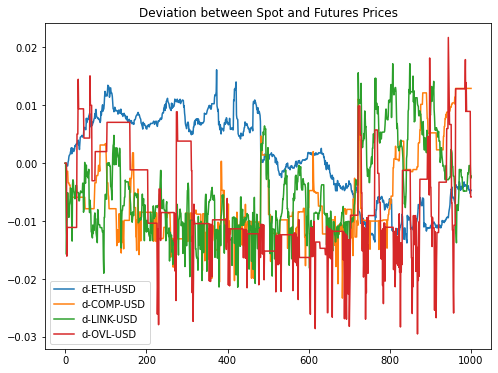

In [19]:
plt.figure(2, figsize=DEFAULT_FIGURE_SIZE);
for ticker in TICKERS_WITH_OVL:
    plt.plot(model_vars_df.loc[:, price_deviation_label(ticker)], label=price_deviation_label(ticker));
plt.legend();
plt.title('Deviation between Spot and Futures Prices');

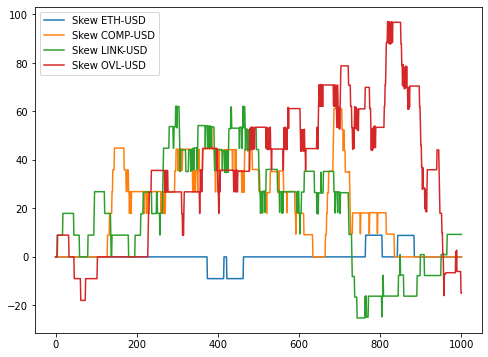

In [20]:
plt.figure(1, figsize=DEFAULT_FIGURE_SIZE);
for ticker in TICKERS_WITH_OVL:
    plt.plot(model_vars_df.loc[:, skew_label(ticker)], label=skew_label(ticker));
plt.legend();

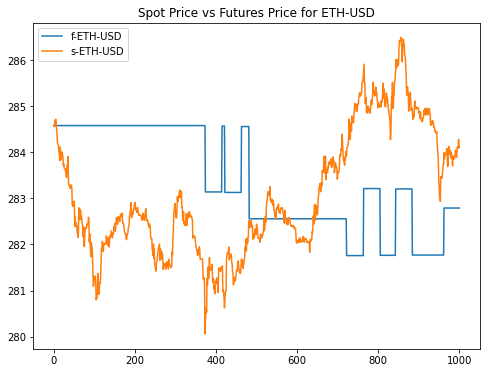

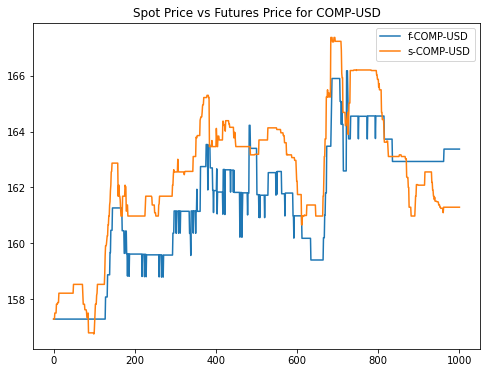

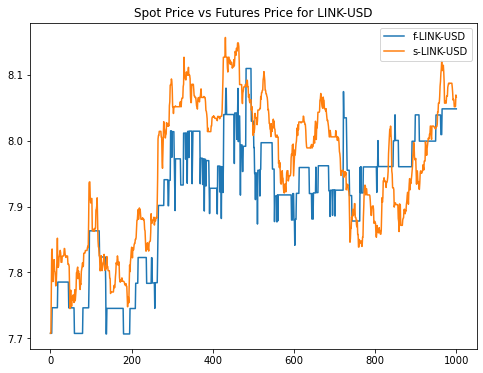

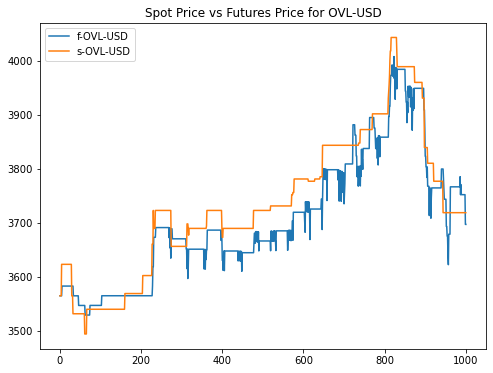

In [21]:
for i, ticker in enumerate(TICKERS_WITH_OVL):
    plt.figure(3+i, figsize=DEFAULT_FIGURE_SIZE);
    plt.plot(model_vars_df.loc[:, futures_price_label(ticker)], label=futures_price_label(ticker));
    plt.plot(model_vars_df.loc[:, spot_price_label(ticker)], label=spot_price_label(ticker));
    plt.title(f'Spot Price vs Futures Price for {ticker}')
    plt.legend();